In [1]:
import os
EXAMPLE_DIR = os.getcwd()
os.chdir(os.path.join('..', '..'))
PROJECT_DIR = os.getcwd()
EXAMPLE_NAME = os.path.basename(EXAMPLE_DIR)
print('EXAMPLE_DIR: ', EXAMPLE_DIR)
print('PROJECT_DIR: ', PROJECT_DIR)

EXAMPLE_DIR:  /Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_two_boxes_packing
PROJECT_DIR:  /Users/kandai/Documents/projects/research/regret_synthesis_toolbox


In [17]:
%load_ext autoreload
%autoreload 2
import gym
from IPython.display import Video, display

import sys
import time
import numpy as np
from typing import List
from pathlib import Path
from collections import defaultdict

sys.path.append(os.path.join(PROJECT_DIR, 'src'))
from src.graph import Graph
from src.graph import graph_factory
from src.config import ROOT_PATH
from src.strategy_synthesis import MultiObjectiveSolver
from src.simulation.simulator import Simulator
from src.graph.trans_sys import FiniteTransSys
from src.graph.pdfa import PDFAGraph


from wombats.systems.minigrid import GYM_MONITOR_LOG_DIR_NAME
from wombats.systems.minigrid import DynamicMinigrid2PGameWrapper, MultiAgentMiniGridEnv

DIR = EXAMPLE_DIR
Graph.graph_dir = DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
debug = True

dfa_config_yaml="config/DFA"
pdfa_config_yaml="config/PDFA"

# Graph Arguments
load_game_from_file = False
plot_minigrid = False
plot_pdfa = True
plot_product = False
finite = True
view = True
save_flag = True
format = 'png'

# Multi-Objective Optimizer Arguments
stochastic = False
adversarial = True
plot_strategies=False
plot_graph_with_strategy = False
plot_graph_with_pareto = False
plot_pareto = True
speedup = True

# Construct DFA and Manually Specify PDFA from DFA 



/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_two_boxes_packing/plots/franka_two_boxes_packing_PDFA.png


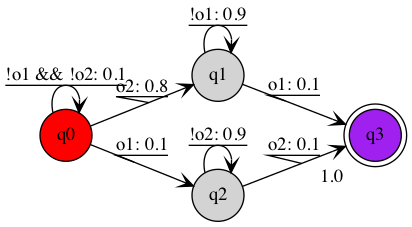

In [63]:
pdfa_config_yaml="config/PDFA"

pdfa = graph_factory.get(
    'PDFA',
    graph_name=f"{EXAMPLE_NAME}_PDFA",
    sc_ltl="Fo1 && Fo2",
    config_yaml=pdfa_config_yaml,
    save_flag=save_flag,
    plot=plot_pdfa,
    view=view,
    format=format)

# Extend a task to multiple people

In [74]:
import copy
import queue
import networkx as nx

def construct_pdfa_for_multiple_people(
    pdfas: List[PDFAGraph],
    names: List[str],
    config_yaml: str,
    graph_name: str,
    save_flag: bool=True):

    """
    A run in each PDFA must reach the accepting state for all people. 
    We assume all possible ways people can reach the (combined) task. 
    """
    init_node = tuple(pdfa.get_initial_states()[0][0] for pdfa in pdfas)
    
    searchQueue = queue.Queue()
    visited = defaultdict(lambda: False)

    searchQueue.put(init_node)
    visited[init_node] = True
    
    product_pdfa = PDFAGraph(graph_name, config_yaml=config_yaml, save_flag=save_flag)
    product_pdfa._graph = nx.MultiDiGraph(name=graph_name)

    product_pdfa.add_state(str(init_node))
    product_pdfa.add_initial_state(str(init_node))

    while not searchQueue.empty():

        _u_prod_node = searchQueue.get()

        for i in range(len(pdfas)):

            u_node = _u_prod_node[i]
            p = pdfas[i]

            for v_node in p._graph.successors(u_node):
                edge_kwargs = p._graph[u_node][v_node]
                node_kwargs = copy.deepcopy(p._graph.nodes[v_node])

                _v_prod_node = tuple(n if i!=j else v_node for j, n in enumerate(_u_prod_node))
                accepts = [p._graph.nodes[n].get('accepting') for n in _v_prod_node]
                accept = all([a if a is not None else False for a in accepts])

                if not visited[_v_prod_node]:
                    searchQueue.put(_v_prod_node)
                    visited[_v_prod_node] = True

                if not product_pdfa._graph.has_node(_v_prod_node):
                    if 'init' in node_kwargs:
                        del node_kwargs['init']
                    node_kwargs['accepting'] = accept
                    product_pdfa.add_state(str(_v_prod_node), **node_kwargs)

                for kwargs in edge_kwargs.values():
                    product_pdfa.add_edge(str(_u_prod_node), str(_v_prod_node), **kwargs)

    return product_pdfa


def construct_pdfa_for_multiple_people_from_one_pdfa(
    pdfa, 
    num_people: int = None, 
    names: List[str] = None,
    **kwargs):

    if num_people is not None:
        names = [f'p{i+1}' for i in range(num_people)]

    pdfas = [copy.deepcopy(pdfa) for i in range(len(names))]
    return construct_pdfa_for_multiple_people(pdfas, names, **kwargs)
    

pdfa_config_yaml="config/ExtendedPDFA"
pdfa = construct_pdfa_for_multiple_people_from_one_pdfa(
    pdfa, 2,
    graph_name=f"{EXAMPLE_NAME}_EXTENDED_PDFA",
    config_yaml=pdfa_config_yaml)

ANDExpression(NotSymbolExpression(o1), NotSymbolExpression(o2)) <class 'src.spot.Parser.ANDExpression'>
ANDExpression(NotSymbolExpression(o1), NotSymbolExpression(o2)) <class 'src.spot.Parser.ANDExpression'>
ANDExpression(NotSymbolExpression(o1), NotSymbolExpression(o2)) <class 'src.spot.Parser.ANDExpression'>
ANDExpression(NotSymbolExpression(o1), NotSymbolExpression(o2)) <class 'src.spot.Parser.ANDExpression'>
SymbolExpression(o2) <class 'src.spot.Parser.SymbolExpression'>
SymbolExpression(o1) <class 'src.spot.Parser.SymbolExpression'>
SymbolExpression(o2) <class 'src.spot.Parser.SymbolExpression'>
SymbolExpression(o1) <class 'src.spot.Parser.SymbolExpression'>
SymbolExpression(o2) <class 'src.spot.Parser.SymbolExpression'>
SymbolExpression(o1) <class 'src.spot.Parser.SymbolExpression'>
SymbolExpression(o2) <class 'src.spot.Parser.SymbolExpression'>
SymbolExpression(o1) <class 'src.spot.Parser.SymbolExpression'>
NotSymbolExpression(o1) <class 'src.spot.Parser.NotSymbolExpression'>
AN

/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_two_boxes_packing/plots/franka_two_boxes_packing_EXTENDED_PDFA.png


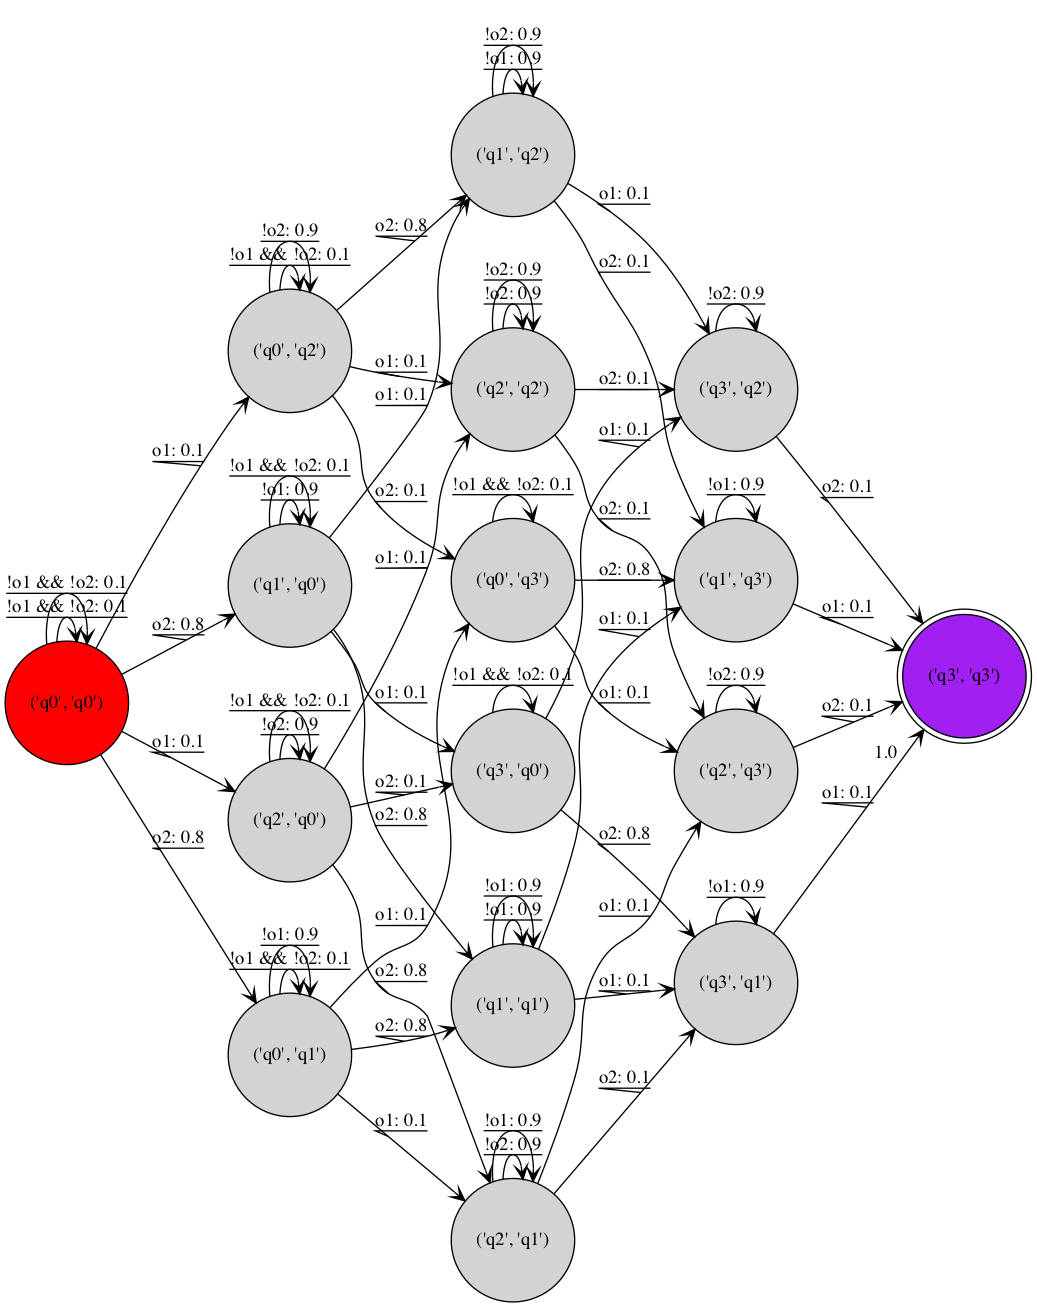

In [65]:
pdfa.plot_graph(view=view, format=format)

# Manually Define Game
Given a list of objects, construct a product graph


In [60]:

def construct_object_graph(object_num: int=1, graph_name: str = None):
    
    if graph_name is None:
        graph_name = f'o{object_num}'

    trans_sys = FiniteTransSys(graph_name, config_yaml=None, save_flag=False)
    trans_sys._graph = nx.MultiDiGraph(name=graph_name)

    trans_sys.add_state('l0', ap='')
    trans_sys.add_state('b1', ap=graph_name)
    trans_sys.add_state('b2', ap=graph_name)
    trans_sys.add_edge('l0', 'b1', actions=f'move_{graph_name}_l0_b1', weight=1)
    trans_sys.add_edge('l0', 'b2', actions=f'move_{graph_name}_l0_b2', weight=1)
    trans_sys.add_initial_state('l0')
    return trans_sys

def construct_graph(
    num_object: int = None, 
    object_names: List[str] = None, 
    save_flag: bool=True, 
    graph_name: str=None):

    if num_object is not None:
        obj_graphs = [construct_object_graph(i+1) for i in range(num_object)]
    elif object_names is not None:
        obj_graphs = [construct_object_graph(graph_name=name) for name in object_names]
    else:
        raise Exception('Either num_object or object_names must be given')

    init_node = tuple(g.get_initial_states()[0][0] for g in obj_graphs)
    
    searchQueue = queue.Queue()
    visited = defaultdict(lambda: False)

    searchQueue.put(('eve', init_node))
    visited[init_node] = True
    
    if graph_name is None:
        graph_name = ''.join([f'o{i+1}' for i in range(num_object)])
    trans_sys = FiniteTransSys(graph_name, config_yaml=None, save_flag=save_flag)
    trans_sys._graph = nx.MultiDiGraph(name=graph_name)

    aps = [i_g._graph.nodes[n]['ap'] for i_g, n in zip(obj_graphs, init_node)]
    ap = ''.join(aps)
    trans_sys.add_state(str(init_node), ap=ap, player='eve')
    trans_sys.add_initial_state(str(init_node))

    while not searchQueue.empty():

        player, _u_prod_node = searchQueue.get()

        for i in range(num_object):

            s = _u_prod_node[i]
            g = obj_graphs[i]

            for n_s in g._graph.successors(s):
                e_kwargs = g._graph[s][n_s]
                
                _v_prod_node = tuple(n if i!=j else n_s for j, n in enumerate(_u_prod_node))

                aps = [i_g._graph.nodes[n]['ap'] for i_g, n in zip(obj_graphs, _v_prod_node)]
                aps = [string for string in aps if len(string)!=0]
                ap = set(aps)
                # ap = set([g._graph.nodes[n_s]['ap']])

                next_player = 'adam' if player == 'eve' else 'eve'

                if not visited[_v_prod_node]:
                    searchQueue.put((next_player, _v_prod_node))
                    visited[_v_prod_node] = True

                if not trans_sys._graph.has_node(_v_prod_node):
                    trans_sys.add_state(str(_v_prod_node), ap=ap, player=next_player)

                for i, kwargs in e_kwargs.items():
                    trans_sys.add_edge(str(_u_prod_node), str(_v_prod_node), **kwargs)

    return trans_sys


In [66]:
trans_sys = construct_graph(2, graph_name=f'{EXAMPLE_NAME}_GAME')

/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_two_boxes_packing/plots/franka_two_boxes_packing_GAME.png


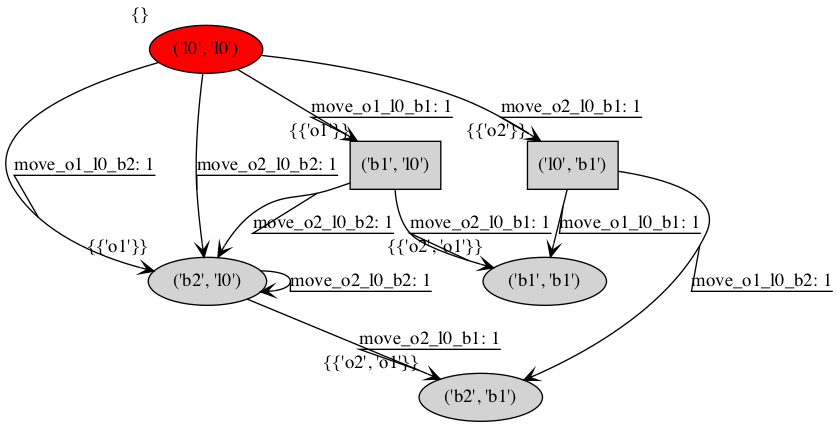

In [67]:
trans_sys.plot_graph(format=format, view=view)

In [77]:
# Product Game Construction
start = time.time()
game = graph_factory.get('ProductGraph',
    graph_name=f'{EXAMPLE_NAME}_ProductAutomaton',
    config_yaml=None,
    trans_sys=trans_sys,
    automaton=pdfa,
    save_flag=True,
    prune=False,
    debug=False,
    absorbing=True,
    finite=finite,
    plot=plot_product,
    integrate_accepting=True,
    view=view,
    format=format)
end = time.time()
print(f'Product Construction took {end-start:.2f} seconds')

Product Construction took 399.32 seconds


/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/src/graph/base.py:537: UserWarning: WARNING: The set of accepting states is empty. Returning an empty list. 
  warnings.warn("WARNING: The set of accepting states is empty. Returning an empty list. ")


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.042733 to fit


/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_two_boxes_packing/plots/franka_two_boxes_packing_ProductAutomaton.png


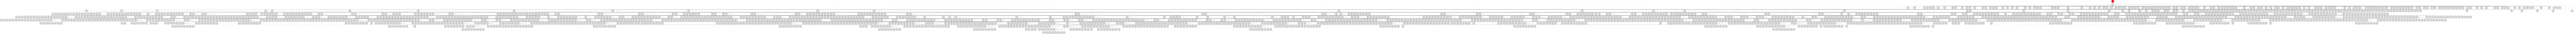

In [78]:
game.plot_graph(view=view, format=format)

In [79]:
solver = MultiObjectiveSolver(game,
                            epsilon=1e-5,
                            max_iteration=300,
                            stochastic=stochastic,
                            adversarial=adversarial)
solver.solve(plot_strategies=plot_strategies,
                plot_graph_with_strategy=plot_graph_with_strategy,
                plot_graph_with_pareto=plot_graph_with_pareto,
                plot_pareto=plot_pareto,
                speedup=speedup,
                debug=debug,
                view=view,
                format=format)

Exception: ('Init', '(\'("(\\\'q0\\\', \\\'q0\\\')", "(\\\'q0\\\', \\\'q0\\\')")\', \'("(\\\'q0\\\', \\\'q0\\\')", "(\\\'q0\\\', \\\'q0\\\')")\')') not in the system's winning region

/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_box_packing/plots/DeterministicStrategyFor(3.0,0.0).png


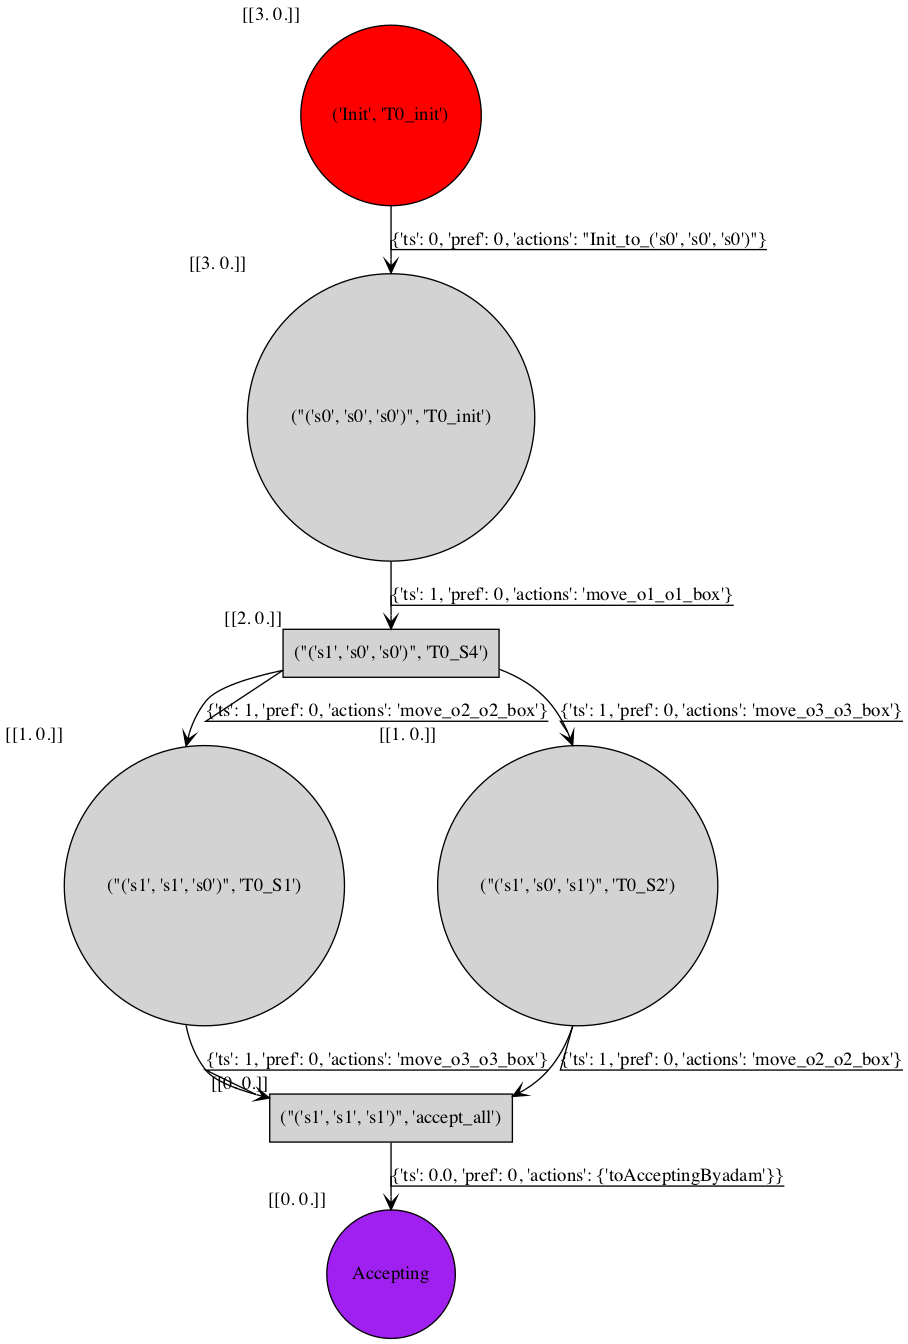

In [ ]:
solver.plot_strategies()